In [1]:
import time
import os
import copy
from tqdm import tqdm

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.io import read_image

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage import io, color
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from zaubi import CustomImageDataset

import ssl
from torchvision.models import resnet50, ResNet50_Weights
from datasets import load_from_disk


ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
DATA_DIR = 'data/mtg-image-data'

BATCH_SIZE = 32
NUM_WORKERS = 4

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [9]:
#load the dataset from disk
dataset = load_from_disk("data/mtg-image-data")
dataset

labels = ['colorless', 'blue', 'black', 'white', 'green', 'red']
color_discrete_map = {'colorless': 'gray', 'blue': 'deepskyblue', 'black': 'black', 'white': 'cornsilk', 'green': 'darkgreen', 'red': 'firebrick'}


In [13]:
# load the model from disk
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
# Modify the last layer of the model
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(labels))
)

transforms = weights.transforms()

model.load_state_dict(torch.load(os.path.join("models_finetuned", "mtg_image_classifier_noDA_5kfCV_SGD_0.001.bs32.pth"), map_location=torch.device('cpu')))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..1.9064132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..

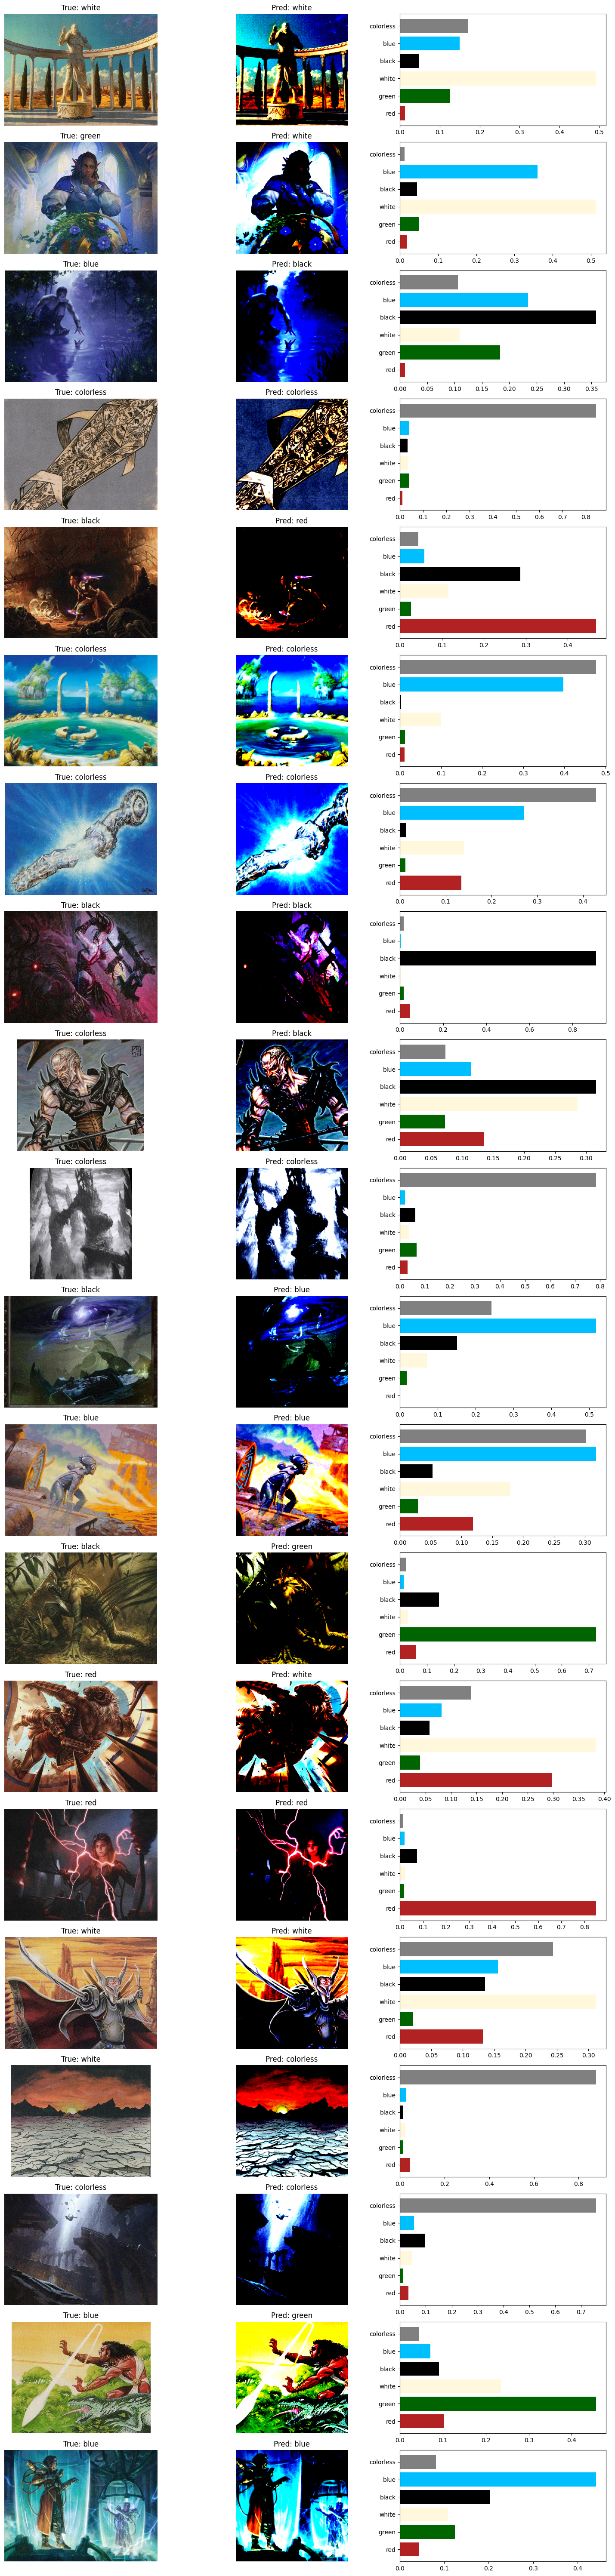

In [20]:
# Make n predictions and the plot the original image, the transformed image, and the probabilities as a bar chart. 
# Put the true label as the title of the original image and the predicted label as the title of the transformed image. 

def visualize_predictions(model, test_dataset, transform, labels_names, n_images=10):
    model.eval()
    model.to(DEVICE)
    
    # Sample n random images
    samples, _ = torch.utils.data.random_split(test_dataset, [n_images, len(test_dataset) - n_images])
    
    # Store original images
    original_images = [sample['image'] for sample in samples]
    
    # Apply transformations
    samples = CustomImageDataset(samples, labels_names, transform=transform)
    
    # Create DataLoader
    test_loader = DataLoader(samples, batch_size=n_images, shuffle=False)
    
    # Prepare the figure
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 3 * n_images))
    
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        
        for j in range(n_images):
            # Original image
            ax = axes[j, 0]
            ax.imshow(original_images[j])
            ax.axis('off')
            ax.set_title(f"True: {labels_names[labels[j].item()]}")
            
            # Transformed image
            ax = axes[j, 1]
            ax.imshow(inputs[j].permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
            ax.set_title(f"Pred: {labels_names[preds[j].item()]}")
            
            # Probabilities
            ax = axes[j, 2]
            y_pos = np.arange(len(labels_names))
            probabilities = probs[j].cpu().detach().numpy()
            colors = [color_discrete_map[labels_names[i]] for i in range(len(labels_names))]
            
            ax.barh(y_pos, probabilities, color=colors)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels_names)
            ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, dataset, transforms, labels, 20)